In [77]:
from pathlib import Path
from typing import List
from itertools import chain
from collections import Counter
import copy
import os

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Text & NLP
import spacy
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, Word2Vec
from gensim.models.phrases import Phrases
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from empath import Empath

# Transformers
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset
import torch

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
from wordcloud import WordCloud

sns.set_theme()

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  # Not an elegant fix for Intel OPENMP problem on Windows. Could 

## Load data

In [3]:
data_path = Path('../data/')

In [4]:
subtitles_tokinezed = pd.read_parquet(data_path.joinpath('processed/subtitles_tokenized.parquet.gzip'))
subtitles_tokinezed.head()

,Wikidata ID,Text,Freebase ID,IMDb ID
0,Q1755660,"[Divine, Comedy, Dante, Alighieri, HELL, art, ...",/m/07jcl5,tt0002130
1,Q2576383,"[MABEL, WHEEL, Parte, Farce, Comedy, lover, wo...",/m/02rd2pn,tt0004277
2,Q2294948,"[fireman, let, house, insuranceand, daughter, ...",/m/09lh9c,tt0006684
3,Q1923676,"[cure, health, spring, throw, liquor, dinner, ...",/m/09t69n,tt0007832
4,Q1070484,"[dog, life, Dawn, scrap, thoroughbred, mongrel...",/m/07mlsy,tt0009018


In [5]:
summaries_tokinezed = pd.read_parquet(data_path.joinpath('processed/summaries_tokinezed.parquet.gzip'))
summaries_tokinezed.head()

,Freebase ID,Text,Wikidata ID,IMDb ID
0,/m/076w2lb,"[Shlykov, hard, work, taxi, driver, Lyosha, sa...",Q2552456,tt0100757
1,/m/0gkz15s,"[nation, Panem, consist, wealthy, Capitol, poo...",Q212965,tt1392170
2,/m/051zjwb,"[Poovalli, Induchoodan, sentence, year, prison...",Q6965425,tt0273870
3,/m/06xtz3,"[Lemon, Drop, Kid, New, York, City, swindler, ...",Q7746905,tt0043733
4,/m/02tqm5,"[seventh, day, Adventist, Church, pastor, Mich...",Q1249239,tt0094924


In [6]:
metadata = pd.read_csv(data_path.joinpath('processed/chars_extended.csv'))
metadata.head()

,movie_freebase_id,movie_id,movie_name,movie_genre,movie_origin,movie_release,box_office_value,director_id,director_name,director_gender,...,cast_3_country,cast_3_birth,cast_3_age_at_release,cast_id_4,cast_4_name,cast_4_gender,cast_4_country,cast_4_birth,cast_4_age_at_release,movie_imdb_id
0,/m/02rjv0t,Q1000394,This Modern Age,drama film,United States of America,1931-08-29,NaN,Q1985392,Nick Grinde,male,...,France,1878-06-02,53.0,Q2831060,Albert Conti,male,United States of America,1887-01-29,44.0,tt0022478
1,/m/0gjdn2_,Q1000174,Tinko,NaN,NaN,1957-01-01,NaN,Q1379822,Herbert Ballmann,male,...,Germany,1898-02-21,59.0,Q1442953,Hans Hardt-Hardtloff,male,Germany,1906-08-08,51.0,tt0131068
2,/m/0g5xtz,Q1000825,Jan Dara,LGBT-related film,Thailand,2001-01-01,NaN,Q360509,Nonzee Nimibutr,male,...,Thailand,1940-01-24,61.0,Q16305292,NaN,male,NaN,1975-03-26,26.0,tt0282628
3,/m/0czdkjd,Q1001102,The Rat Savior,horror film,Socialist Federal Republic of Yugoslavia,1976-10-26,NaN,Q3199956,Krsto Papić,male,...,Croatia,1932-01-04,44.0,Q12628320,Branko Špoljar,male,NaN,1914-01-05,62.0,tt0074701
4,/m/0f1r9p,Q1000826,Guns of the Magnificent Seven,Western film,United States of America,1969-01-01,NaN,Q450601,Paul Wendkos,male,...,United States of America,1914-07-24,55.0,Q465643,George Rigaud,male,Argentina,1905-08-11,64.0,tt0064395


#### Get movie release dates from metada table

In [7]:
movie_release = metadata.set_index('movie_id').loc[subtitles_tokinezed['Wikidata ID'],'movie_release']
subtitles_tokinezed['year'] = movie_release.copy().values

# Take entries with movie release dates
subtitles_with_dates = subtitles_tokinezed[subtitles_tokinezed['year'].notna()].copy()

# Only keep years and sort wrt years
subtitles_with_dates['year'] = subtitles_with_dates['year'].apply(lambda x: int(x.split('-')[0]))
subtitles_with_dates.sort_values('year', inplace=True)
subtitles_with_dates.head()

,Wikidata ID,Text,Freebase ID,IMDb ID,year
22571,Q2913387,"[doc, pill, sure, work, sure, don, hear, compl...",/m/0gj9h_4,tt1202028,1890
12937,Q1210171,"[Flamingo, Road, town, street, social, success...",/m/02_1qn,tt0241373,1891
13390,Q6555342,"[moral, tale, bakery, girl, MONCEAU, Paris, Vi...",/m/0gx1hz2,tt0256884,1896
25590,Q1141772,"[dad, socialist, kulak, dad, come, dad, come, ...",/m/02vmcc2,tt1728115,1896
26841,Q8049397,"[fund, knowledge, discipline, ideal, hold, pre...",/m/0gx1419,tt2262465,1896


In [8]:
# Not that our `metadata` table has been augmented with Wikidata and contains more complete release date information than CMU dataset
mask = summaries_tokinezed['Freebase ID'].isin(metadata['movie_freebase_id'])
movie_release = metadata.set_index('movie_id').loc[summaries_tokinezed.loc[mask, 'Wikidata ID'],'movie_release']
summaries_tokinezed.loc[mask, 'year'] = movie_release.copy().values

# Take entries with movie release dates
summaries_with_dates = summaries_tokinezed[summaries_tokinezed['year'].notna()].copy()

# Only keep years and sort wrt years
summaries_with_dates['year'] = summaries_with_dates['year'].apply(lambda x: int(x.split('-')[0]))
summaries_with_dates.sort_values('year', inplace=True)
summaries_with_dates.head()

,Freebase ID,Text,Wikidata ID,IMDb ID,year
20052,/m/07mgtk,"[queen, wish, naughty, daughter, turn, raven, ...",Q875764,None,1815
20713,/m/0jq3g,"[scene, film, stationary, camera, screen, larg...",Q470705,tt0000005,1893
23174,/m/02q8pr6,"[film, consist, series, animation, beach, cont...",Q2535572,tt0000015,1894
32127,/m/02q1zd3,"[James, Corbett, Peter, Courtney, specially, a...",Q2563406,tt0000007,1894
20679,/m/02q23xk,"[find, father, suffer, financial, problem, Jer...",Q6876874,tt0000009,1894


## Word Embeddings

In [8]:
N_INTERVALS = 5

subtitles_with_dates['length'] = subtitles_with_dates['Text'].apply(len)
total_length = subtitles_with_dates['length'].sum()
bin_edges = np.linspace(start=0, stop=1, num=N_INTERVALS+1)*total_length
subtitles_with_dates['length_cumulative'] = subtitles_with_dates['length'].cumsum()

In [9]:
def assign_bin(cumulative_sum, bin_edges):
    thresholds = cumulative_sum <= bin_edges
    bin_id = np.where(thresholds)[0][0] #  Bin id is the minimum threshold level the cumulative value exceeds
    return bin_id

subtitles_with_dates['interval_id'] = subtitles_with_dates['length_cumulative'].apply(assign_bin, bin_edges=bin_edges)

In [10]:
# Control
subtitles_with_dates.groupby('interval_id').apply(lambda x:x['length'].sum())

interval_id
1    14901212
2    14905224
3    14903447
4    14903090
5    14906021
dtype: int64

In [43]:
WINDOW_SIZE = 5

In [45]:
word2vec_models = {}


for group_id, group in tqdm(subtitles_with_dates.groupby('interval_id')):
    docs = [list(doc) for doc in group['Text'].tolist()]
                
    model = Word2Vec(sentences=docs, vector_size=100, window=WINDOW_SIZE, min_count=15, workers=8)
    word2vec_models[group_id] = model

  0%|          | 0/5 [00:00<?, ?it/s]

In [46]:
for k,v in word2vec_models.items():
    v.save(f'../models/subtitle_word2vec/interval_{k}_winsize_{WINDOW_SIZE}.model')

### Analyze the results

In [49]:
word2vec_models = {}
WINDOW_SIZE = 5 # Either 5 or 10 is available

for k in range(1, 6):
    word2vec_models[k] = Word2Vec.load(f"../models/subtitle_word2vec/interval_{k}_winsize_{WINDOW_SIZE}.model")

In [50]:
for k,v in word2vec_models.items():
    df = subtitles_with_dates[subtitles_with_dates['interval_id']==k]
    year_min, year_max = df['year'].min(), df['year'].max()
    
    print(f'Top words released to gay in movies between {year_min}-{year_max}')
    for item in v.wv.most_similar('gay'):
        print('\t',item)
        
    print()

Top words released to gay in movies between 1890-1972
	 ('carefree', 0.7681794166564941)
	 ('cheerful', 0.7379952073097229)
	 ('brighten', 0.6614827513694763)
	 ('gloomy', 0.6449736952781677)
	 ('dreary', 0.6204192638397217)
	 ('enchanting', 0.6202699542045593)
	 ('lark', 0.6100409626960754)
	 ('romantic', 0.6048668622970581)
	 ('delightful', 0.5856819748878479)
	 ('charming', 0.5841920971870422)

Top words released to gay in movies between 1972-1994
	 ('lesbian', 0.6742017865180969)
	 ('homosexual', 0.6011388897895813)
	 ('fag', 0.5714848041534424)
	 ('queer', 0.5496288537979126)
	 ('fickle', 0.5420777201652527)
	 ('groupie', 0.5392196178436279)
	 ('heterosexual', 0.5369699597358704)
	 ('Gay', 0.5342585444450378)
	 ('dame', 0.5322725772857666)
	 ('loner', 0.5127857327461243)

Top words released to gay in movies between 1994-2003
	 ('lesbian', 0.758385419845581)
	 ('bisexual', 0.7411475777626038)
	 ('homosexual', 0.7285181879997253)
	 ('homo', 0.6543673872947693)
	 ('heterosexual', 0.6

In [51]:
for k,v in word2vec_models.items():
    df = subtitles_with_dates[subtitles_with_dates['interval_id']==k]
    year_min, year_max = df['year'].min(), df['year'].max()
    
    print(f'Top words released to lesbian in movies between {year_min}-{year_max}')
    for item in v.wv.most_similar('woman'):
        print('\t',item)
        
    print()

Top words released to lesbian in movies between 1890-1972
	 ('man', 0.700378954410553)
	 ('wife', 0.5636851787567139)
	 ('husband', 0.5421378016471863)
	 ('mature', 0.5064458847045898)
	 ('child', 0.49710771441459656)
	 ('attractive', 0.49701419472694397)
	 ('widow', 0.4942302703857422)
	 ('intuition', 0.493818074464798)
	 ('female', 0.49175140261650085)
	 ('alike', 0.4889388680458069)

Top words released to lesbian in movies between 1972-1994
	 ('man', 0.6777275800704956)
	 ('attractive', 0.5791079998016357)
	 ('grown', 0.5634806156158447)
	 ('husband', 0.5538429021835327)
	 ('sex', 0.5482300519943237)
	 ('wife', 0.5363627672195435)
	 ('lib', 0.5348953008651733)
	 ('lesbian', 0.5064201951026917)
	 ('female', 0.5059494376182556)
	 ('male', 0.49886825680732727)

Top words released to lesbian in movies between 1994-2003
	 ('man', 0.6890328526496887)
	 ('seduce', 0.6155197620391846)
	 ('attractive', 0.5964050889015198)
	 ('grown', 0.5886889696121216)
	 ('husband', 0.5413578748703003)
	 ('

In [52]:
for k,v in word2vec_models.items():
    df = subtitles_with_dates[subtitles_with_dates['interval_id']==k]
    year_min, year_max = df['year'].min(), df['year'].max()
    
    print(f'Top words released to woman in movies between {year_min}-{year_max}')
    for item in v.wv.most_similar('lesbian'):
        print('\t',item)
        
    print()

Top words released to woman in movies between 1890-1972
	 ('sex', 0.7563758492469788)
	 ('neurotic', 0.6520167589187622)
	 ('Jealousy', 0.6487810611724854)
	 ('sexual', 0.6443471312522888)
	 ('mature', 0.6090291738510132)
	 ('perverted', 0.6071037650108337)
	 ('possessive', 0.605632483959198)
	 ('adolescent', 0.6053624749183655)
	 ('sexually', 0.6051648855209351)
	 ('intercourse', 0.5932011008262634)

Top words released to woman in movies between 1972-1994
	 ('sex', 0.7093116641044617)
	 ('gay', 0.6742018461227417)
	 ('intercourse', 0.6682419180870056)
	 ('sexual', 0.6661431789398193)
	 ('nymphomaniac', 0.6591166853904724)
	 ('homosexual', 0.6498680114746094)
	 ('possessive', 0.64862459897995)
	 ('voyeur', 0.6464447379112244)
	 ('impotent', 0.6304382085800171)
	 ('perverted', 0.6260538697242737)

Top words released to woman in movies between 1994-2003
	 ('gay', 0.7583854794502258)
	 ('bisexual', 0.7397061586380005)
	 ('homosexual', 0.7219098210334778)
	 ('dyke', 0.6675923466682434)
	 (

## Sentiment Analysis

C:\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### Helper Functions for Sentiment Analysis

In [10]:
def build_term_contexts(row, keyword:str, window_size:int = 10)-> List[dict]:
    '''
    For a given keyword, searches through all the tokenized text and records each occureneces of a token
    and its surround context window with a defined size.  
    '''
    
    doc_array = np.array(row['Text'])
    doc_len = len(doc_array)
    occurences = np.where(keyword == doc_array)[0] # Find occurences of the keyword
    contexts = []
    
    # For each occurence, capture its context windows and save them with their related metada
    for occ in occurences:
        min_index, max_index = max(0, occ-window_size), min(doc_len, occ+window_size)
        context = doc_array[min_index:max_index] # Extract a context window
        
        # Add the current context to the list with the corresponding metada
        contexts.append({
            'Wikidata ID': row['Wikidata ID'],
            'IMDb ID': row['IMDb ID'],
            'Freebase ID': row['Freebase ID'],
            'year':row['year'],
            'Context': context})
    
    return contexts


def extract_sentences(row, keyword:str, path:Path = data_path.joinpath('raw/subtitles'))-> List[dict]:
    '''
    For a given keyword, load preprocessed but not tokenized subtitles and extract sentences in which the keyword appears. 
    '''
    
    doc_array = np.array(row['Text'])
    doc_len = len(doc_array)
    
    # First check if the keyword is part of the tokenized text to filter out unnecessary loading of text.
    occurences = np.where(keyword == doc_array)[0] 
    if len(occurences) == 0: 
        return []
    
    # Load the subtitle file
    with open(path.joinpath(row['IMDb ID'] + '.txt'), 'r', encoding='utf-8') as file:
        text = file.readlines()
        
    # In the preprocessed subtitle file, each line is a sentence.
    # Keep a sentence if it includes the keyword.
    text = [sent.replace('\n', ' ') for sent in text]
    text = [sent for sent in text if keyword in sent]
    
    # Save the found sentences with metada
    sentences = [{
            'Wikidata ID': row['Wikidata ID'],
            'IMDb ID': row['IMDb ID'],
            'Freebase ID': row['Freebase ID'],
            'year':row['year'],
            'Text': sent} 
        for sent in text]
    
    return sentences


def vader_score(text, analyzer, score_type='compound') -> float:
    '''
    Analyze a text with Vader sentiment analyzer and return the compound score.
    '''
    sentiment_scores = analyzer(text)
    return sentiment_scores[score_type]

def expand_transformer_score(row, output:dict) -> dict:
    '''
    Map different output conventions of sentiment analysis transformer models to 
    a predefined dictionary structure. Useful to try out different models.
    '''
    
    sentiment = {}
    for sent in output:
        label = sent['label']
        score = sent['score']
        
        if label in ['NEGATIVE', 'negative', 'LABEL_0']:
            sentiment['Negative'] = score
        elif label in ['POSITIVE', 'positive', 'LABEL_2']:
            sentiment['Positive'] = score
        else:
            sentiment['Neutral'] = score
                
    label = sorted(sentiment, key=sentiment.get)[-1]
    
    for feat in ['Negative', 'Neutral', 'Positive']:
        row[feat] = sentiment[feat]
        
    label_map = {'Negative':-1, 'Neutral':0, 'Positive':+1}
    row['Label'] = label_map[label]
    
    
    return row

def transfomer_score(row, pipeline, batch:bool=True):
    '''
    Analyze a text with a transformer-based sentiment analyzer on CPU and return scores and the label.
    '''
    text = row['Text']
    output = pipeline(text)
    
    if batch==True:
        output = output[0] # Batch size is 1 on CPU
        
    return expand_transformer_score(row, output)

### Models

In [11]:
# Lexicon-based sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Transformer-based sentiment analyzer
model ='cardiffnlp/twitter-roberta-base-sentiment-latest'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sentiment_pipeline = pipeline(task='sentiment-analysis', model=model, device=device, top_k=None)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Analysis

In [22]:
KEYWORDS = [
    'man', 
    'woman', 
    'gay', 
    'lesbian', 
    'transexual', 
    'bisexual', 
    'queer', 
    'american', 
    'russian', 
    'chinese', 
    'indian', 
    'mexican',
    'african'
]

In [23]:
for keyword in tqdm(KEYWORDS):
    # For a given keyword, extract its context windows for all its occurences
    contexts = subtitles_with_dates.apply(build_term_contexts, keyword=keyword, axis=1).copy()
    contexts = list(chain(*contexts)) # Concatenate lists
    df_contexts = pd.DataFrame(contexts)
    df_contexts['Text'] = df_contexts['Context'].apply(lambda x: ' '.join(x))
    
    # For a given keyword, read all raw sentences from subtitles including the keyword
    sentences = subtitles_with_dates.apply(extract_sentences, keyword=keyword, axis=1)
    sentences = list(chain(*sentences)) # Concatenate lists
    df_sentences = pd.DataFrame(sentences)
    
    # Apply Vader sentiment analysis
    df_contexts['vader_score'] = df_contexts['Text'].apply(vader_score, analyzer=vader_analyzer.polarity_scores)
    df_sentences['vader_score'] = df_sentences['Text'].apply(vader_score, analyzer=vader_analyzer.polarity_scores)
    

    # Transformer based sentiment analysis on context windows
    ds = KeyDataset(Dataset.from_pandas(df_contexts), 'Text')
    scores = []
    for idx, output in tqdm(zip(df_contexts.index, sentiment_pipeline(ds, batch_size=256)), total=len(df_contexts), leave=False):
        scores.append(expand_transformer_score(df_contexts.loc[idx].copy(), output=output))
    df_contexts = pd.DataFrame(scores)
    
    # Transformer based sentiment analysis on sentences
    ds = KeyDataset(Dataset.from_pandas(df_sentences), 'Text')
    scores = []
    for idx, output in tqdm(zip(df_sentences.index, sentiment_pipeline(ds, batch_size=256)), total=len(df_sentences), leave=False):
        scores.append(expand_transformer_score(df_sentences.loc[idx].copy(), output=output))
    df_sentences = pd.DataFrame(scores)
    
    # Save results for plotting
    df_contexts.to_parquet(data_path.joinpath(f'processed/sentiment_analysis/{keyword}_contexts.parquet.gzip'))
    df_sentences.to_parquet(data_path.joinpath(f'processed/sentiment_analysis/{keyword}_sentences.parquet.gzip'))

  0%|          | 0/13 [00:00<?, ?it/s]

C:\anaconda3\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/1774 [00:00<?, ?it/s]

C:\anaconda3\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/51 [00:00<?, ?it/s]

### Plotting results

In [44]:
keyword = 'american'
df_contexts = pd.read_parquet(data_path.joinpath(f'processed/sentiment_analysis/{keyword}_contexts.parquet.gzip'))
df_contexts.head()

,Wikidata ID,IMDb ID,Freebase ID,year,Context,Text,vader_score,Negative,Neutral,Positive,Label
0,Q2913387,tt1202028,/m/0gj9h_4,1890,"[suppose, set, deranged, teenager, rise, Water...",suppose set deranged teenager rise Waterford H...,0.4767,0.406013,0.574056,0.019931,0
1,Q2913387,tt1202028,/m/0gj9h_4,1890,"[think, lesson, lesson, lesson, tolerance, loo...",think lesson lesson lesson tolerance look indu...,0.7506,0.053287,0.800739,0.145974,0
2,Q1210171,tt0241373,/m/02_1qn,1891,"[time, county, time, figure, improve, reputati...",time county time figure improve reputation pla...,-0.7096,0.425535,0.551942,0.022523,0
3,Q3231990,tt0225500,/m/027yc9t,1900,"[deaf, air, raid, Golly, American, mind, reade...",deaf air raid Golly American mind reader yeah ...,0.2960,0.087780,0.626605,0.285615,0
4,Q3231990,tt0225500,/m/027yc9t,1900,"[raid, yeah, hurry, yeah, guess, come, fun, ye...",raid yeah hurry yeah guess come fun yeah sit t...,0.9169,0.008160,0.350837,0.641003,1


In [67]:
def basic_plotting(df, feat='Label', N=15):
    '''
    Basic plottig for sentiment analysis. Should be replaced with something better for the data story.
    '''
    df= df.copy()
    fig, axes = plt.subplots(nrows=1, ncols=3, dpi=300, figsize=(15,5))
    
    sns.lineplot(df, x='year', y='Label', ax=axes[0])
    axes[0].set_title('Year average')
    axes[0].set_xlim([1900, 2010])
    
    
    df['interval_id'] = pd.cut(df['year'], N, labels=range(N))
    scores = []
    years = []
    for idx, group in df.groupby('interval_id'):
        scores.append(group['Label'].mean())
        years.append(group['year'].min())
    sns.lineplot(x=years, y=scores, ax=axes[1])
    axes[1].set_title('Binned years with equal sized bins')
    axes[1].set_xlim([1900, 2010])
    
    
    df['interval_id'] = pd.qcut(df['year'], N, labels=range(N))
    scores = []
    years = []
    for idx, group in df.groupby('interval_id'):
        scores.append(group['Label'].mean())
        years.append(group['year'].min())
    sns.lineplot(x=years, y=scores, ax=axes[2])
    axes[2].set_title('Binned years with equal number of samples')
    axes[2].set_xlim([1900, 2010])

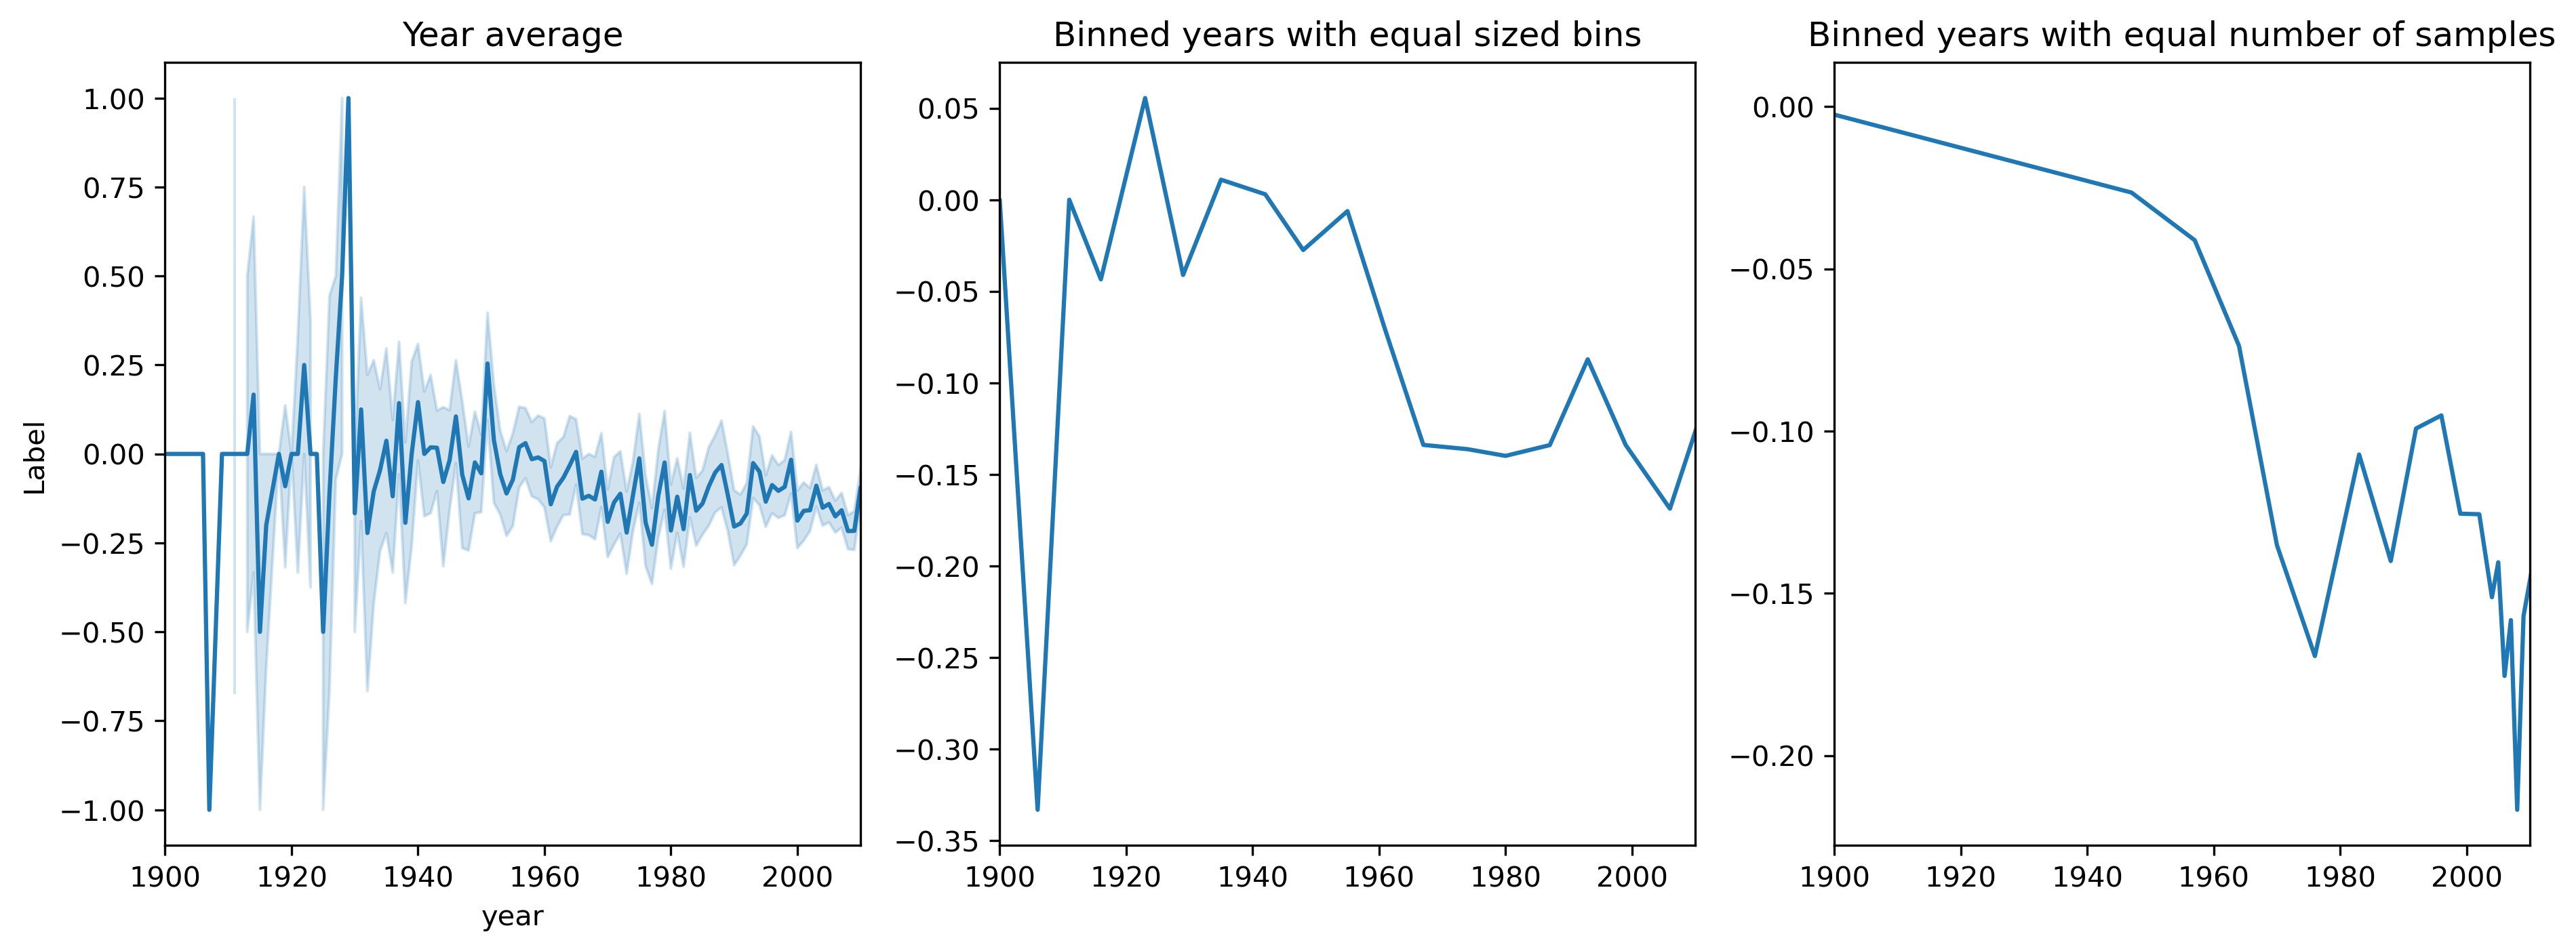

In [68]:
basic_plotting(df_contexts, feat='Label', N=20)

### Topic modelling

In [79]:

lexicon = Empath()

lexicon.create_category('lgbt', ['rights', 'lesbian', 'gay', 'trans', 'transsexual', 'queer','asexual','heterosexual'], model='fiction')


["lesbian", "gay", "bisexual", "homosexual", "homophobic", "lesbians", "incest", "gays", "womanizer", "gay_people", "man_whore", "manwhore", "asexual", "homophobe", "same_gender", "man-whore", "racist", "gold_digger", "pansexual", "gay", "sexist", "date", "homosexuals", "gay", "reject", "Directioner", "dating", "heterosexual", "hypocrite", "groupie", "transgender", "real_person", "stereotype", "ladies_man", "same_sex", "cheater", "Muslim", "bi", "heartless_bitch", "fuck_buddy", "bad_kid", "homosexuality", "scumbag", "virgin", "whore", "bad_influence", "hater", "snob", "bad_person", "rebel", "second_choice", "playboy", "misfit", "complete_jerk", "cheating", "total_nerd", "sexuality", "heartbreaker", "fuck_buddies", "prude", "gay", "mean", "liars", "feminist", "celebrity", "religious", "delinquent", "slut", "saint", "charity_case", "gay_best_friend", "spoiled_brat", "disrespectful", "sexual_orientation", "virgins", "secondly", "slag", "own_opinion", "related", "benefits", "directioner", 

In [83]:
docs = subtitles_tokinezed.copy()
docs['Full_text'] = docs['Text'].apply(lambda x: ' '.join(x))
docs['lexicon_score'] = docs.apply(lambda x: lexicon.analyze(x['Full_text'], categories = ['lgbt'])['lgbt'], axis=1)

docs = docs.loc[docs['lexicon_score']>0, 'Text'].tolist()
docs = [list(doc) for doc in docs]

In [84]:
# Add bigrams with term-frequency>15 to docs.
bigram = Phrases(docs, min_count=15)

for doc in docs:
    for token in bigram[doc]:
        if '_' in token:
            # Token is a bigram, add to document.
            doc.append(token)

In [85]:
dictionary = Dictionary(docs)

max_freq = 0.5 # Remove rare tokens.
min_wordcount = 5 # Remove common tokens.
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

corpus = [dictionary.doc2bow(doc) for doc in docs] # Bag-of-Words representations of documents

In [87]:
# Latent Dirichlet Analysis
params = {'passes': 10, 'random_state': 0}
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=8,
                passes=params['passes'], random_state=params['random_state'])

In [94]:
model.save(f'../models/lda.model')

### Visualize and analyze the results

In [96]:
model = LdaMulticore.load(f'../models/lda.model')

In [97]:
model.show_topics(num_words=5)

[(0,
  '0.003*"ain" + 0.003*"gun" + 0.002*"wanna" + 0.002*"shit" + 0.002*"Miss"'),
 (1,
  '0.008*"fuck" + 0.006*"shit" + 0.006*"fucking" + 0.004*"wanna" + 0.004*"mom"'),
 (2,
  '0.003*"Miss" + 0.002*"husband" + 0.002*"Father" + 0.002*"evening" + 0.002*"doctor"'),
 (3,
  '0.004*"Sir" + 0.003*"police" + 0.003*"daughter" + 0.002*"sister" + 0.002*"dad"')]

In [89]:
model.show_topic(0, 20)

[('ain', 0.0026843126),
 ('gun', 0.0025762317),
 ('wanna', 0.002040291),
 ('shit', 0.0019533243),
 ('Miss', 0.0017613183),
 ('police', 0.0017100212),
 ('murder', 0.0014359344),
 ('gentleman', 0.0014197492),
 ('John', 0.0014034451),
 ('horse', 0.0013804662),
 ('cop', 0.0013801669),
 ('figure', 0.001379682),
 ('Joe', 0.0013740963),
 ('New', 0.0013250348),
 ('office', 0.0013188892),
 ('million', 0.0012964999),
 ('ride', 0.0012588907),
 ('report', 0.0012384073),
 ('doctor', 0.0012308137),
 ('bet', 0.0011947919)]

In [90]:
model.show_topic(1, 20)

[('fuck', 0.00846957),
 ('shit', 0.0063859243),
 ('fucking', 0.0062886314),
 ('wanna', 0.0039291503),
 ('mom', 0.0036413074),
 ('music', 0.0032744103),
 ('dad', 0.002763066),
 ('ain', 0.0026131556),
 ('ass', 0.002488949),
 ('dog', 0.0021340651),
 ('cool', 0.0020820955),
 ('honey', 0.0018961879),
 ('bitch', 0.0018589161),
 ('whoa', 0.0017348069),
 ('party', 0.0016961417),
 ('scream', 0.0016552834),
 ('hmm', 0.0016099961),
 ('wow', 0.0015868862),
 ('Jesus', 0.0015149816),
 ('movie', 0.0014900614)]

In [91]:
model.show_topic(2, 20)

[('Miss', 0.0025798916),
 ('husband', 0.0021342637),
 ('Father', 0.0019514322),
 ('evening', 0.0019476896),
 ('doctor', 0.0017576799),
 ('daughter', 0.001752187),
 ('gentleman', 0.0017255621),
 ('Lord', 0.0016975494),
 ('darling', 0.001670277),
 ('sister', 0.001510337),
 ('Sir', 0.0014681064),
 ('letter', 0.0014496036),
 ('forgive', 0.0013829101),
 ('goodbye', 0.0013760476),
 ('war', 0.0013479907),
 ('kiss', 0.0013477685),
 ('dance', 0.0013410243),
 ('wonderful', 0.0012115471),
 ('dress', 0.0011960136),
 ('king', 0.0011702969)]

In [92]:
model.show_topic(3, 20)

[('Sir', 0.0037919271),
 ('police', 0.0025845142),
 ('daughter', 0.0025122145),
 ('sister', 0.0024046244),
 ('dad', 0.0021236055),
 ('law', 0.0021170152),
 ('mom', 0.0020525525),
 ('boss', 0.0017202337),
 ('film', 0.0016495314),
 ('war', 0.0016056879),
 ('marriage', 0.0014960743),
 ('doctor', 0.0014668064),
 ('power', 0.0014493059),
 ('husband', 0.0014256714),
 ('alright', 0.0013324178),
 ('uncle', 0.0013323558),
 ('human', 0.0013166651),
 ('attack', 0.0012392368),
 ('Uncle', 0.0012179898),
 ('study', 0.0012163025)]

In [93]:
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

C:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## WordClouds

In [117]:
text = ' '.join(df_contexts['Text'])
wc = WordCloud(max_font_size=40).generate(text)

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\anaconda3\lib\site-packages\wordcloud

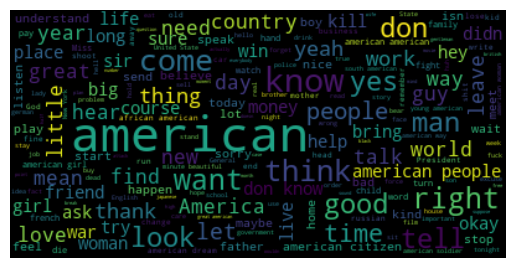

In [118]:
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [119]:
contexts = df_contexts['Context'].tolist()
contexts = list(chain(*contexts)) # Concatenate lists

term_counts = Counter(contexts)

In [120]:
wc = WordCloud(max_font_size=40).generate_from_frequencies(term_counts)

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\anaconda3\lib\site-packages\wordcloud

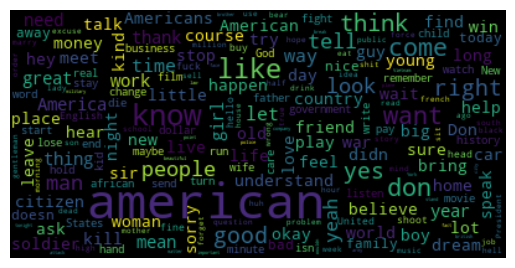

In [121]:
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()